In [1]:
from xgboost import XGBClassifier

import gc
import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from Interaction_effect_features import get_data

import warnings
warnings.filterwarnings('ignore')
np.seterr(divide = 'ignore')
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def last_preprocessing(data_dict,feature_columns,dependent_variable,dataset):
    
    if dataset == 'regression':
        columns = ['AdjustedLeadTime_Quartile_countRankEncoded', 'CumulativeNumberOfRooms_Quartile_percentEncoded', 'CumulativeNumberOfRooms_Quartile_countRankEncoded', 'CumulativeNumberOfRooms_Quartile_MeanEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_percentEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_countRankEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_MeanEncoded', 'CumulativeNumberOfRoomsNet_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_percentEncoded', 'CumulativeRevenue_Quartile_countEncoded', 'CumulativeRevenue_Quartile_percentEncoded', 'CumulativeRevenue_Quartile_countRankEncoded', 'CumulativeRevenue_Quartile_MeanEncoded', 'CumulativeRevenueSubstract_Quartile_percentEncoded', 'CumulativeRevenueSubstract_Quartile_countRankEncoded', 'CumulativeRevenueNet_Quartile_percentEncoded', 'CumulativeRevenueNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_MeanEncoded','AdjustedLeadTime_Quartile_percentEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_percentEncoded','AdjustedLeadTime_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_percentEncoded', 'CumulativeRevenueSubstract_Quartile_countEncoded', 'CumulativeRevenueSubstract_Quartile_MeanEncoded', 'CumulativeRevenueNet_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_countEncoded','AdjustedLeadTime_Quartile_MeanEncoded', 'CumulativeNumberOfRooms_Quartile_countEncoded', 'CumulativeRevenueNet_Quartile_countRankEncoded','AdjustedLeadTimeCumulativeRevenue_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_percentEncoded']
    else:
        columns = ['LeadTime_Quartile_countEncoded','LeadTime_Quartile_percentEncoded','LeadTime_Quartile_countRankEncoded','LeadTime_Quartile_MeanEncoded','ADR_Quartile_countEncoded','ADR_Quartile_percentEncoded','ADR_Quartile_countRankEncoded','ADR_Quartile_MeanEncoded']
    
    for feature in columns:
        if feature in feature_columns and feature in data_dict['data_external_test'].columns:
            data_dict['data_external_test'][feature] = data_dict['data_external_test'][feature].astype(int)
            data_dict['data_validation_test'][feature] = data_dict['data_validation_test'][feature].astype(int)

            for index in data_dict['fold_dict'].keys():
                data_dict['fold_dict'][index]['fold_training'][feature] = data_dict['fold_dict'][index]['fold_training'][feature].astype(int)
                data_dict['fold_dict'][index]['fold_test'][feature] = data_dict['fold_dict'][index]['fold_test'][feature].astype(int)
    
#     print('ReservedRoomType_countEncoded' in data_dict['fold_dict'][3]['fold_training'])
#     print('ReservedRoomType_countEncoded' in data_dict['fold_dict'][3]['fold_test'])
#     print('ReservedRoomType_countEncoded' in data_dict['data_validation_test'])
#     print('ReservedRoomType_countEncoded' in data_dict['data_external_test'])
    
    fold_training = data_dict['fold_dict'][1]['fold_training'][feature_columns+dependent_variable]
    fold_test = data_dict['fold_dict'][1]['fold_test'][feature_columns+dependent_variable]
    data_validation_test = data_dict['data_validation_test'][feature_columns+dependent_variable]
    data_external_test = data_dict['data_external_test'][feature_columns+dependent_variable]
    
    #append
    training_df = fold_training.append([fold_test, data_validation_test], ignore_index=True)
    training_df.reset_index(inplace=True,drop=True)
    
    return training_df,data_external_test

In [4]:
#'HotelCancellations', 'CouponRecommendation', 'PredictRoomBooking','CarSales'

#features_classification = 
with open(r"D:\Results\ResultPickle\HotelCancellations\best_columns_SA_HotelCancel_xgboost.pickle", "rb") as features_classification:
    features_classification = pickle.load(features_classification)

features_classification_reordered = ['LeadTime_Sqrt','ADR_Sqrt','Country_Encoded','Agent_Encoded','TotalOfSpecialRequests_Sqrt', 'ReservedRoomType_Encoded', 'Company_Encoded', 'PreviousCancellations_Sqrt', 'RequiredCarParkingSpaces_Encoded', 'CustomerType_percentEncoded', 'IsRepeatedGuest_MeanEncoded', 'MarketSegment_MeanEncoded', 'AssignedRoomType_Encoded', 'MarketSegment_percentEncoded', 'DepositType_Encoded', 'ADR_Quartile_Encoded', 'Meal_MeanEncoded', 'ArrivalDateWeekNumber_Encoded', 'LessCancellation_percentEncoded', 'LeadTime_Quartile_countRankEncoded', 'IsRepeatedGuest_percentEncoded', 'IsRepeatedGuest_countEncoded', 'CustomerType_Encoded', 'PreviousBookingsNotCanceledMoreThan14_countEncoded', 'AgentRecoded_Encoded', 'CountryRecoded_percentEncoded', 'ArrivalDateYear_MeanEncoded', 'ReservedRoomType_countEncoded', 'ArrivalDateDayOfMonth_countRankEncoded', 'LeadTime_Quartile_countEncoded', 'Meal_countRankEncoded', 'ADR_Quartile_countRankEncoded', 'ArrivalDateDayOfMonth_Encoded', 'ArrivalDateMonth_Encoded', 'BookingChanges_Sqrt', 'LeadTime_Quartile_Encoded', 'DistributionChannel_Encoded', 'ArrivalDateMonth_countRankEncoded', 'ArrivalDateDayOfMonth_countEncoded', 'PreviousBookingsNotCanceledMoreThan14_MeanEncoded', 'ArrivalDateYear_countRankEncoded', 'CountryRecoded_countEncoded', 'PreviousCancellationsMoreThan5_percentEncoded','PreviousCancellationsMoreThan5_MeanEncoded', 'ArrivalDateYear_percentEncoded', 'CompanyRecoded_Encoded', 'ReservedRoomType_countRankEncoded', 'AgentRecoded_countEncoded', 'LessCancellation_Encoded', 'CountryRecoded_MeanEncoded', 'DepositType_countRankEncoded', 'CompanyRecoded_percentEncoded', 'ADR_Quartile_MeanEncoded', 'PreviousCancellationsMoreThan5_Encoded', 'MarketSegment_countRankEncoded', 'AgentRecoded_MeanEncoded', 'CustomerType_MeanEncoded']
    
problem = 'HotelCancellations'
data_dict_classification,dependent_variable_classification,categorical_linear,categorical_tree,categorical_features,numerical_features_linear,numerical_features_tree,ordinal_features,ordinal_features_engineered = get_data(problem)

#create single dataframe
training_df_classification,data_external_test_classification = last_preprocessing(data_dict=data_dict_classification,
                                                                                  feature_columns=features_classification_reordered,
                                                                                  dependent_variable=dependent_variable_classification,
                                                                                  dataset='classification')

# Train Models

In [5]:
classification_model = XGBClassifier(n_estimators=200,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
classification_model.fit(training_df_classification[features_classification_reordered],training_df_classification[dependent_variable_classification])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

## Individual Conditional Expectation Plots

In [6]:
from sklearn.inspection import PartialDependenceDisplay

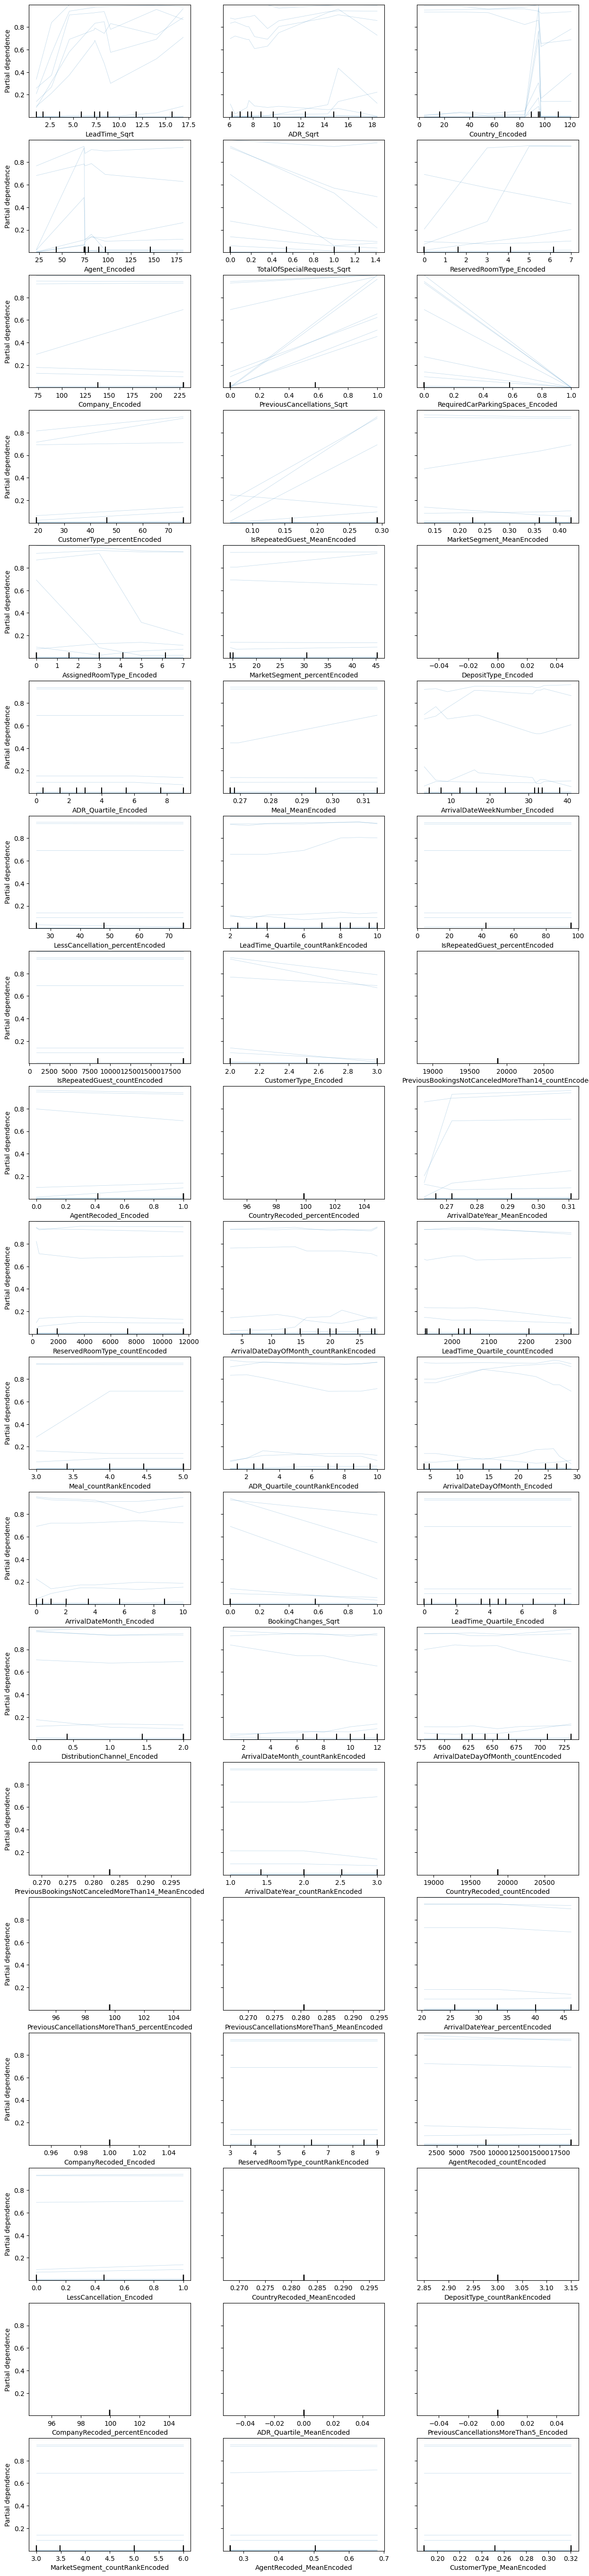

In [7]:
plt.rcParams["figure.figsize"] = (15,70)
#plt.constrained_layout=False
#plt.subplot_tool()
#plt.subplots_adjust(top=1,bottom=0.9)
PartialDependenceDisplay.from_estimator(estimator=classification_model, 
                                        X = training_df_classification[features_classification_reordered].head(10),
                                        features = features_classification_reordered,
                                        feature_names= features_classification_reordered,
                                        kind='individual')

#plt.rcParams["figure.figsize"] = (20,20)

plt.show()

## Local interpretable model-agnostic explanations

In [9]:
import lime.lime_tabular

In [52]:
explainer = lime.lime_tabular.LimeTabularExplainer(training_df_classification[features_classification_reordered].values,
                                                   feature_names=features_classification_reordered,
                                                   class_names=list(training_df_classification[dependent_variable_classification[0]].unique()),
                                                   discretize_continuous=True)

row_number_in_test_data = 3
exp = explainer.explain_instance(data_external_test_classification[features_classification_reordered].iloc[row_number_in_test_data],
                                 classification_model.predict_proba,
                                 num_features=len(features_classification_reordered),
                                 top_labels=1)

exp.show_in_notebook()

## Counterfactual Model Explanations

In [11]:
from alibi.explainers import ALE, plot_ale

In [12]:
xgb_ale = ALE(classification_model.predict,
             feature_names=features_classification_reordered,
             target_names=dependent_variable_classification)

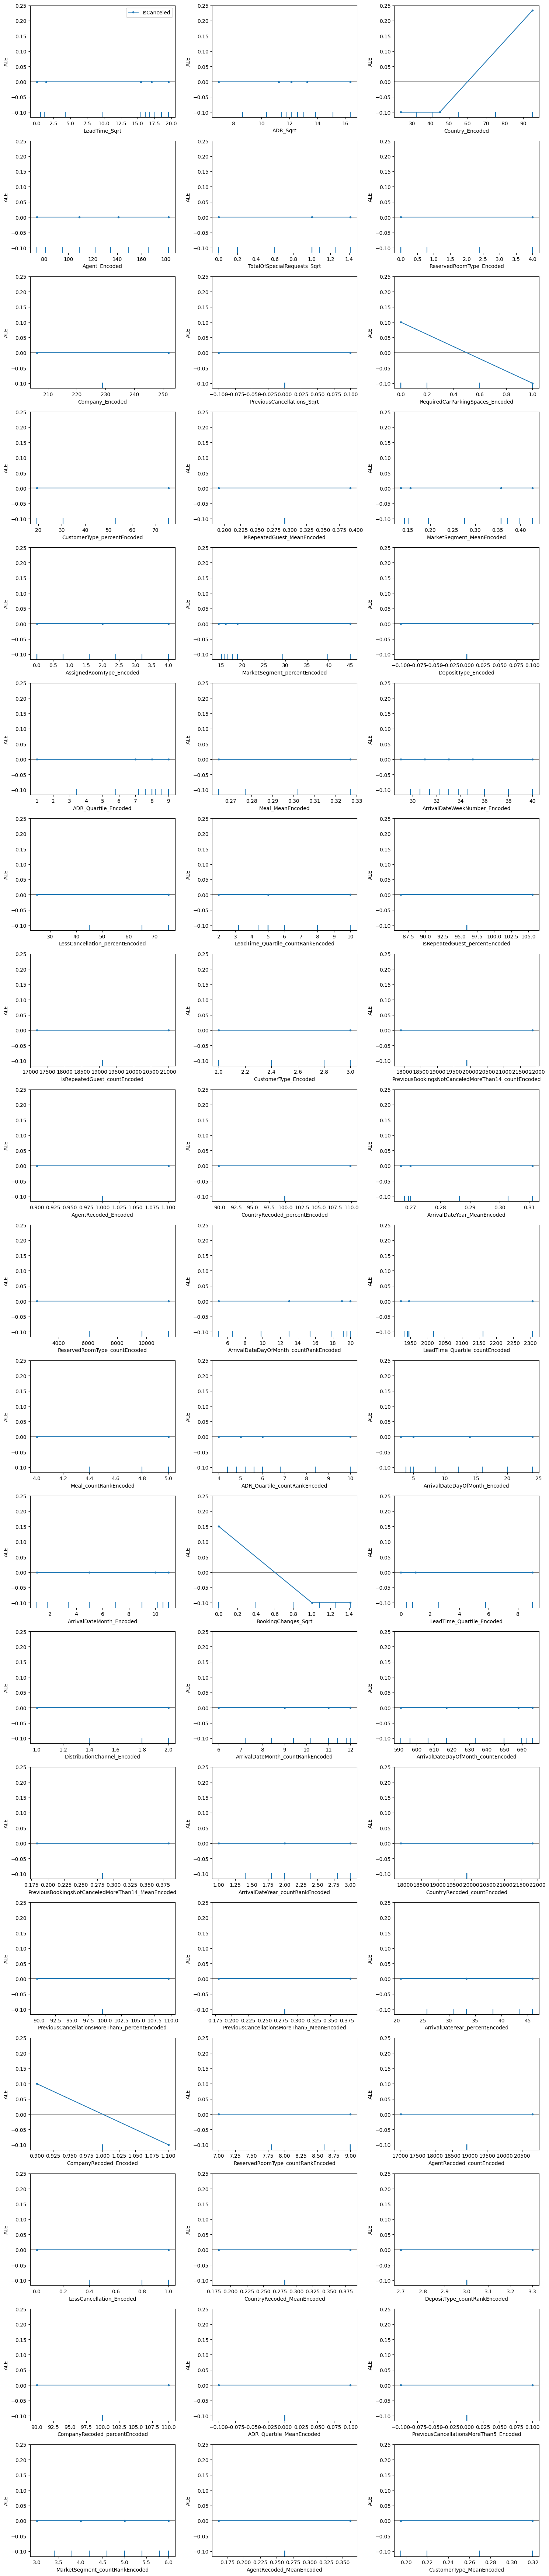

In [18]:
row_number_in_test_data = 3
xgb_exp = xgb_ale.explain(data_external_test_classification[features_classification_reordered].head().values)#iloc[[row_number_in_test_data], :].values)
plt.rcParams["figure.figsize"] = (15,70)
plot_ale(xgb_exp)
plt.show()

## SHAP

In [19]:
import shap

In [20]:
shap_values = shap.TreeExplainer(classification_model).shap_values(
    data_external_test_classification[features_classification_reordered].iloc[[row_number_in_test_data], :])

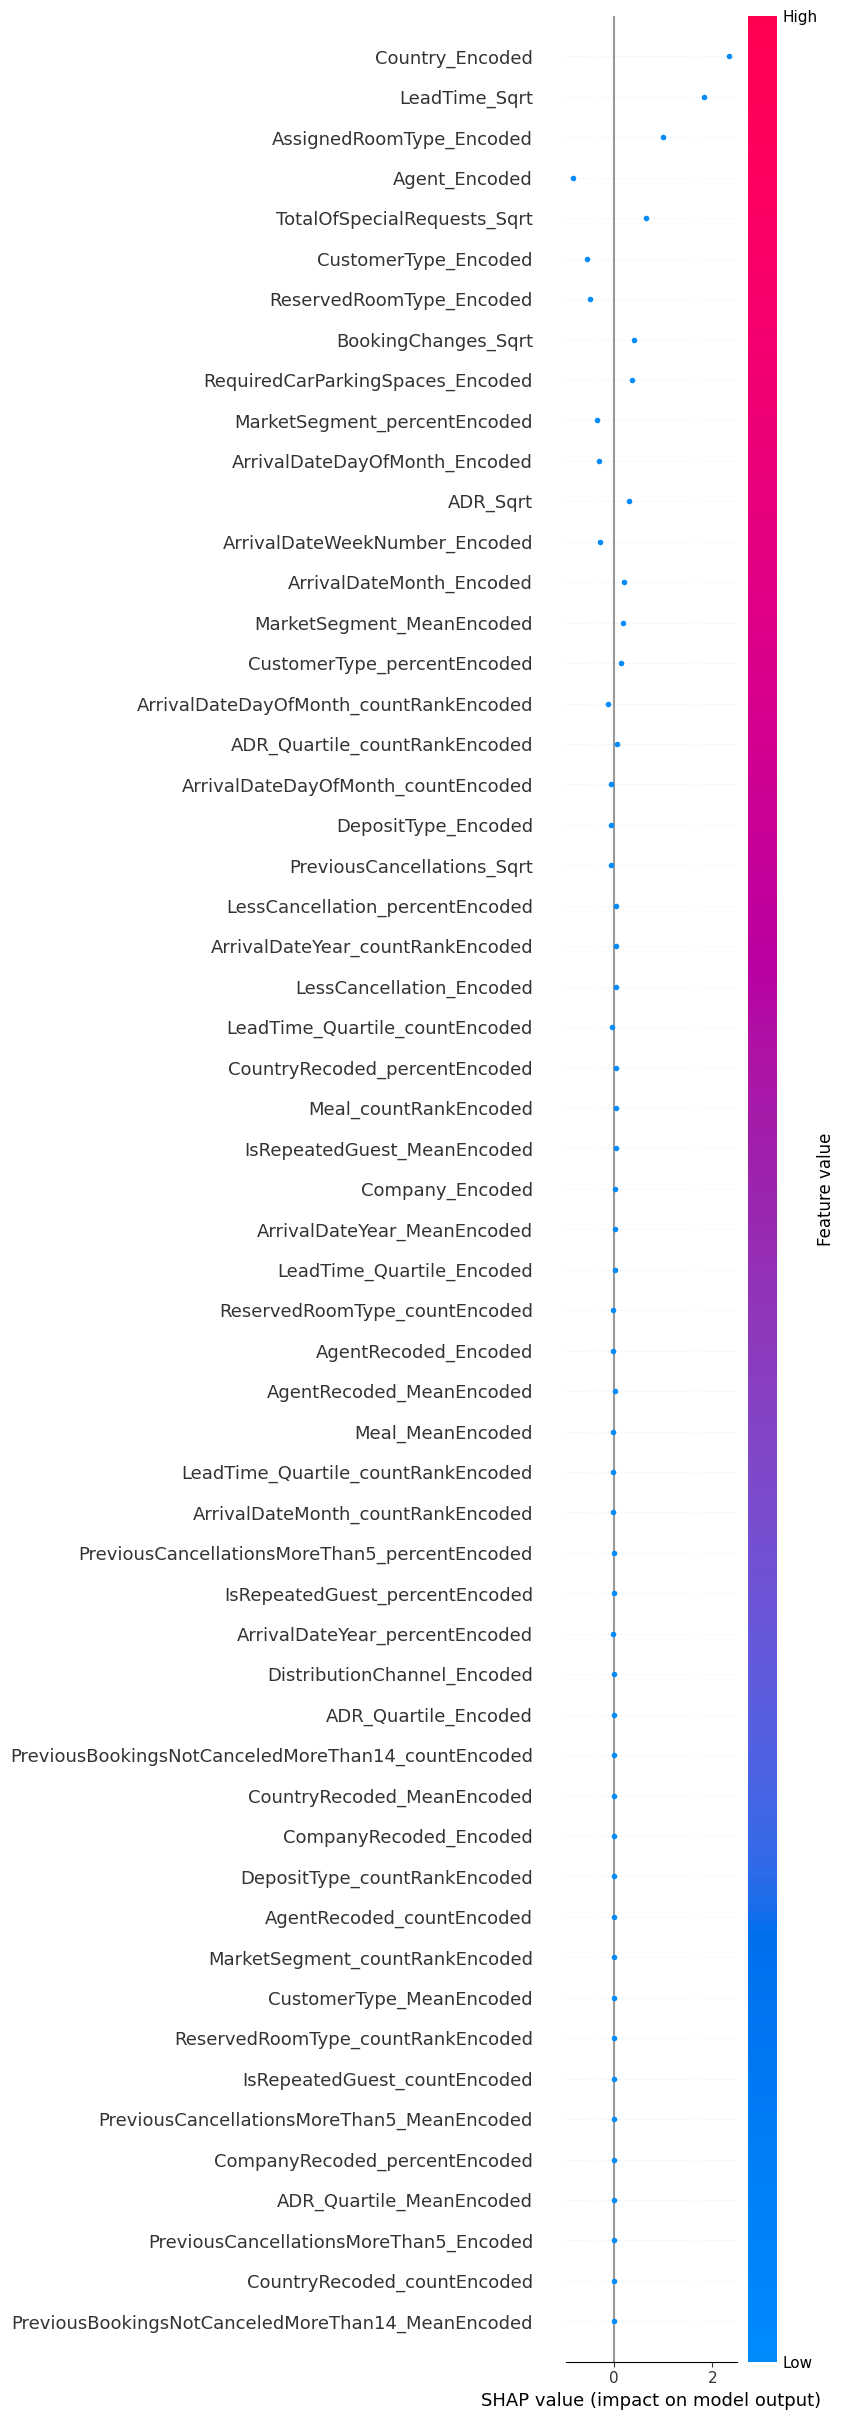

In [21]:
shap.summary_plot(shap_values,
                  data_external_test_classification[features_classification_reordered].iloc[[row_number_in_test_data], :],
                  max_display=len(features_classification_reordered))